## Set Up Environment


In [1]:
import os
import uuid

import alifedata_phyloinformatics_convert as apc
from Bio import Phylo
from colorclade._biopython_sort_tree import biopython_sort_tree
from hstrat import hstrat
from hstrat import _auxiliary_lib as hstrat_aux
from hsurf import hsurf
from matplotlib import pyplot as plt
from matplotlib import patches as mpl_patches
import numpy as np
import pandas as pd
import tqdist
from tqdm.notebook import tqdm


## Configure Experiment


Set up random number generator. (Do not edit.)


In [2]:
seed = 1

seed


1

In [3]:
from hstrat._auxiliary_lib import seed_random

seed_random(seed)


Helper functions.


In [4]:
from pylib._phyloviz import (
    logify_phylo,
    make_policy,
    make_reconstructed_rosettatree,
    prune_100,
    plot2,
    calc_tqdist_distance,
)


## Generate Phylogeny

Use simple evolutionary simulation to generate a phylogenetic history to test reconstruction process on.


In [5]:
num_generations = 100000


In [6]:
true_phylogeny_df = pd.read_parquet("https://osf.io/zrdhg/download")


In [7]:
full_true_phylogeny_df = true_phylogeny_df.copy()


## Downsample Phylogeny


In [8]:
downsample = 500
print(f"{downsample=}")
if downsample:
    print(f"downsampling to {downsample=}")
    leaf_ids = hstrat_aux.alifestd_find_leaf_ids(true_phylogeny_df)
    downsample_ids = np.random.default_rng(seed).choice(
        leaf_ids,
        downsample,
        replace=False,
    )
    true_phylogeny_df["extant"] = False
    true_phylogeny_df.loc[
        true_phylogeny_df["id"].isin(downsample_ids),
        "extant",
    ] = True
    true_phylogeny_df = hstrat_aux.alifestd_prune_extinct_lineages_asexual(
        true_phylogeny_df,
        mutate=True,
    )
    assert (
        len(hstrat_aux.alifestd_find_leaf_ids(true_phylogeny_df)) == downsample
    )

    true_phylogeny_df = hstrat_aux.alifestd_collapse_unifurcations(
        true_phylogeny_df,
        mutate=True,
    )
    true_phylogeny_df = hstrat_aux.alifestd_to_working_format(
        true_phylogeny_df,
        mutate=True,
    ).reset_index(drop=True)


downsample=500
downsampling to downsample=500


## Generate Reconstruction

Generate genome annotations as if tracking phylogeny in distributed environment.
Then run reconstruction proess to estimate true phylogeny from generated annotations.


annotation_capacity_strata=32


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

annotation_capacity_strata=64


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

annotation_capacity_strata=256


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

annotation_capacity_strata=32


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/tmp/ipykernel_5841/2767003336.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


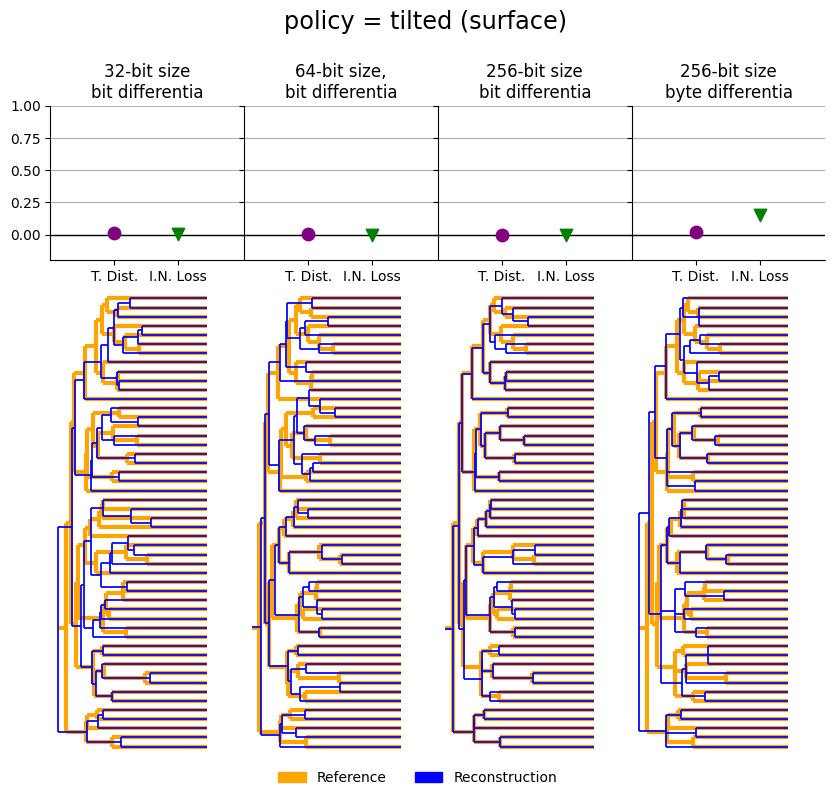

In [9]:
trees = [
    make_reconstructed_rosettatree(
        "surf-tilted",
        annotation_size_bits=32,
        differentia_width_bits=1,
        true_phylogeny_df=true_phylogeny_df,
        num_generations=num_generations,
    ),
    make_reconstructed_rosettatree(
        "surf-tilted",
        annotation_size_bits=64,
        differentia_width_bits=1,
        true_phylogeny_df=true_phylogeny_df,
        num_generations=num_generations,
    ),
    make_reconstructed_rosettatree(
        "surf-tilted",
        annotation_size_bits=256,
        differentia_width_bits=1,
        true_phylogeny_df=true_phylogeny_df,
        num_generations=num_generations,
    ),
    make_reconstructed_rosettatree(
        "surf-tilted",
        annotation_size_bits=256,
        differentia_width_bits=8,
        true_phylogeny_df=true_phylogeny_df,
        num_generations=num_generations,
    ),
]
fig, (axs1, axs2) = plt.subplots(
    2, 4, gridspec_kw={"wspace": 0, "hspace": 0.1}, height_ratios=[1, 3]
)
fig.set_size_inches(10, 8)

plot2(apc.RosettaTree(logify_phylo(true_phylogeny_df)), trees[0], seed, axs2[0])
plot2(apc.RosettaTree(logify_phylo(true_phylogeny_df)), trees[1], seed, axs2[1])
plot2(apc.RosettaTree(logify_phylo(true_phylogeny_df)), trees[2], seed, axs2[2])
plot2(apc.RosettaTree(logify_phylo(true_phylogeny_df)), trees[3], seed, axs2[3])

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

# Create the legend patches
orange_patch = mpl_patches.Patch(color="orange", label="Reference")
blue_patch = mpl_patches.Patch(color="blue", label="Reconstruction")

# Create a custom legend without a frame
legend = fig.legend(
    handles=[orange_patch, blue_patch],
    loc="lower center",
    ncol=2,
    frameon=False,
)

axs1[0].set_title("32-bit size\nbit differentia")
axs1[1].set_title("64-bit size,\nbit differentia")
axs1[2].set_title("256-bit size\nbit differentia")
axs1[3].set_title("256-bit size\nbyte differentia")
# Remove axes borders except for bottom, and remove y-axis tick/labels
for i, ax in enumerate(axs1):
    ax.axes.get_xaxis().set_visible(True)
    ax.axes.get_yaxis().set_visible(True)
    ax.set_xticks([0.33, 0.66])
    ax.set_xticklabels(["T. Dist.", "I.N. Loss"])
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)
    if i:
        ax.set_yticklabels([])

for tree, ax in zip(trees, axs1):
    tripdist = calc_tqdist_distance(true_phylogeny_df, tree.as_alife)[
        "triplet_distance"
    ]
    # tripdist = hstrat_aux.alifestd_estimate_triplet_distance_asexual(
    #     hstrat_aux.alifestd_collapse_unifurcations(true_phylogeny_df),
    #     hstrat_aux.alifestd_collapse_unifurcations(tree.as_alife),
    #     taxon_label_key="taxon_label",
    #     strict=True,
    #     progress_wrap=tqdm,
    #     mutate=False,
    #     confidence=0.9,
    #     precision=0.05,
    # )
    innernodeloss = 1 - hstrat_aux.alifestd_count_inner_nodes(
        hstrat_aux.alifestd_collapse_unifurcations(tree.as_alife),
    ) / hstrat_aux.alifestd_count_inner_nodes(
        hstrat_aux.alifestd_collapse_unifurcations(true_phylogeny_df),
    )
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.2, 1)
    ax.axhline(y=0, color="black", linewidth=1)
    ax.grid(axis="y")
    ax.scatter(
        [0.33],
        [tripdist],
        color=["purple"],
        marker="o",
        clip_on=False,
        s=80,
        zorder=10,
    )
    ax.scatter(
        [0.66],
        [innernodeloss],
        color=["green"],
        marker="v",
        clip_on=False,
        s=80,
        zorder=10,
    )


# Adjust layout
plt.subplots_adjust(bottom=0.05, top=0.86)

fig.suptitle("policy = tilted (surface)", size="xx-large")
os.makedirs("outplots", exist_ok=True)
plt.savefig(
    "outplots/a=examplepanel+policy=surf-tilted+regime=drift+ext=.pdf",
    bbox_inches="tight",
)


annotation_capacity_strata=32


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

annotation_capacity_strata=64


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

annotation_capacity_strata=256


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

annotation_capacity_strata=32


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/tmp/ipykernel_5841/1585515275.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


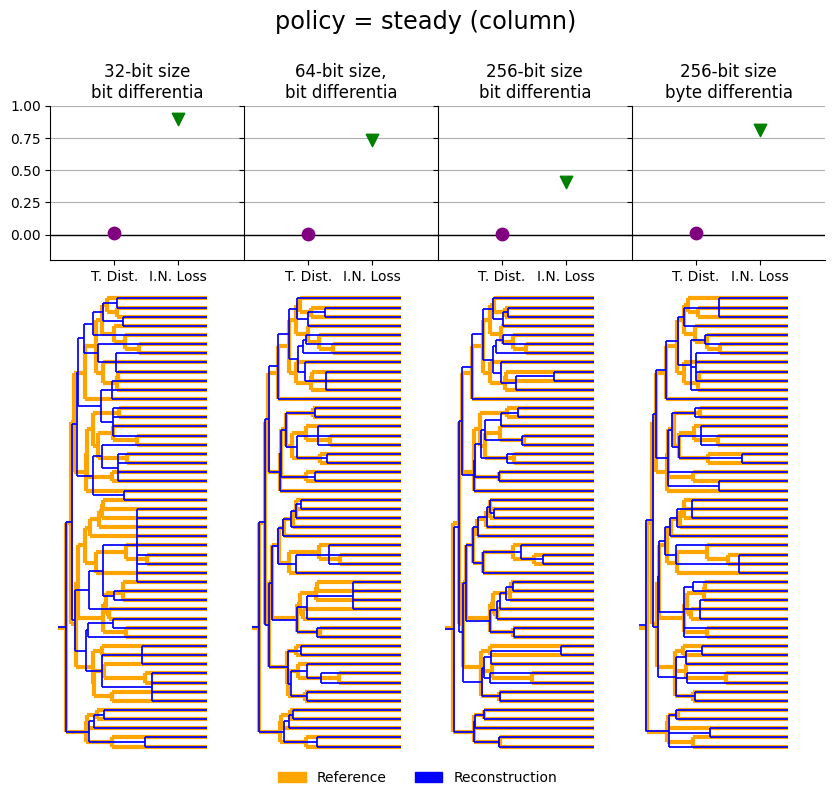

In [10]:
trees = [
    make_reconstructed_rosettatree(
        "col-steady",
        annotation_size_bits=32,
        differentia_width_bits=1,
        true_phylogeny_df=true_phylogeny_df,
        num_generations=num_generations,
    ),
    make_reconstructed_rosettatree(
        "col-steady",
        annotation_size_bits=64,
        differentia_width_bits=1,
        true_phylogeny_df=true_phylogeny_df,
        num_generations=num_generations,
    ),
    make_reconstructed_rosettatree(
        "col-steady",
        annotation_size_bits=256,
        differentia_width_bits=1,
        true_phylogeny_df=true_phylogeny_df,
        num_generations=num_generations,
    ),
    make_reconstructed_rosettatree(
        "col-steady",
        annotation_size_bits=256,
        differentia_width_bits=8,
        true_phylogeny_df=true_phylogeny_df,
        num_generations=num_generations,
    ),
]
fig, (axs1, axs2) = plt.subplots(
    2, 4, gridspec_kw={"wspace": 0, "hspace": 0.1}, height_ratios=[1, 3]
)
fig.set_size_inches(10, 8)

plot2(apc.RosettaTree(logify_phylo(true_phylogeny_df)), trees[0], seed, axs2[0])
plot2(apc.RosettaTree(logify_phylo(true_phylogeny_df)), trees[1], seed, axs2[1])
plot2(apc.RosettaTree(logify_phylo(true_phylogeny_df)), trees[2], seed, axs2[2])
plot2(apc.RosettaTree(logify_phylo(true_phylogeny_df)), trees[3], seed, axs2[3])

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

# Create the legend patches
orange_patch = mpl_patches.Patch(color="orange", label="Reference")
blue_patch = mpl_patches.Patch(color="blue", label="Reconstruction")

# Create a custom legend without a frame
legend = fig.legend(
    handles=[orange_patch, blue_patch],
    loc="lower center",
    ncol=2,
    frameon=False,
)

axs1[0].set_title("32-bit size\nbit differentia")
axs1[1].set_title("64-bit size,\nbit differentia")
axs1[2].set_title("256-bit size\nbit differentia")
axs1[3].set_title("256-bit size\nbyte differentia")
# Remove axes borders except for bottom, and remove y-axis tick/labels
for i, ax in enumerate(axs1):
    ax.axes.get_xaxis().set_visible(True)
    ax.axes.get_yaxis().set_visible(True)
    ax.set_xticks([0.33, 0.66])
    ax.set_xticklabels(["T. Dist.", "I.N. Loss"])
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)
    if i:
        ax.set_yticklabels([])

for tree, ax in zip(trees, axs1):
    tripdist = calc_tqdist_distance(true_phylogeny_df, tree.as_alife)[
        "triplet_distance"
    ]
    # tripdist = hstrat_aux.alifestd_estimate_triplet_distance_asexual(
    #     hstrat_aux.alifestd_collapse_unifurcations(true_phylogeny_df),
    #     hstrat_aux.alifestd_collapse_unifurcations(tree.as_alife),
    #     taxon_label_key="taxon_label",
    #     strict=True,
    #     progress_wrap=tqdm,
    #     mutate=False,
    #     confidence=0.9,
    #     precision=0.05,
    # )
    innernodeloss = 1 - hstrat_aux.alifestd_count_inner_nodes(
        hstrat_aux.alifestd_collapse_unifurcations(tree.as_alife),
    ) / hstrat_aux.alifestd_count_inner_nodes(
        hstrat_aux.alifestd_collapse_unifurcations(true_phylogeny_df),
    )
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.2, 1)
    ax.axhline(y=0, color="black", linewidth=1)
    ax.grid(axis="y")
    ax.scatter(
        [0.33],
        [tripdist],
        color=["purple"],
        marker="o",
        clip_on=False,
        s=80,
        zorder=10,
    )
    ax.scatter(
        [0.66],
        [innernodeloss],
        color=["green"],
        marker="v",
        clip_on=False,
        s=80,
        zorder=10,
    )


# Adjust layout
plt.subplots_adjust(bottom=0.05, top=0.86)

fig.suptitle("policy = steady (column)", size="xx-large")
os.makedirs("outplots", exist_ok=True)
plt.savefig(
    "outplots/a=examplepanel+policy=col-steady+regime=drift+ext=.pdf",
    bbox_inches="tight",
)


In [11]:
import datetime

datetime.datetime.now().isoformat()


'2024-05-16T07:08:51.279976'

In [12]:
%load_ext watermark
%watermark


Last updated: 2024-05-16T07:08:51.289762+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.22.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.5.0-1021-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit



In [13]:
locals()


{'__name__': '__main__',
 '__doc__': 'Automatically created module for IPython interactive environment',
 '__package__': None,
 '__loader__': None,
 '__spec__': None,
 '__builtin__': <module 'builtins' (built-in)>,
 '__builtins__': <module 'builtins' (built-in)>,
 '_ih': ['',
  'import os\nimport uuid\n\nimport alifedata_phyloinformatics_convert as apc\nfrom Bio import Phylo\nfrom colorclade._biopython_sort_tree import biopython_sort_tree\nfrom hstrat import hstrat\nfrom hstrat import _auxiliary_lib as hstrat_aux\nfrom hsurf import hsurf\nfrom matplotlib import pyplot as plt\nfrom matplotlib import patches as mpl_patches\nimport numpy as np\nimport pandas as pd\nimport tqdist\nfrom tqdm.notebook import tqdm',
  'seed = 1\n\nseed',
  'from hstrat._auxiliary_lib import seed_random\n\nseed_random(seed)',
  'from pylib._phyloviz import (\n    logify_phylo,\n    make_policy,\n    make_reconstructed_rosettatree,\n    prune_100,\n    plot2,\n    calc_tqdist_distance,\n)',
  'num_generations =